In [1]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json
from lovely_numpy import lo
import cv2

/datagrid/personal/baljibil/repos/env-vitpose/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  skip = False
  for joint_vis in annot_truth[i]['joints_vis']:
    if joint_vis == 0:
      skip = True
      break
  if skip:
    continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)


len:  22246
X shape:  (14975, 17, 2)
y shape: (14975, 16, 2)
box scale: (14975,)
box center: (14975, 2)


In [3]:
print(lo(X))
print(lo(y))

array[14975, 17, 2] n=509150 (3.9Mb) x∈[-124.436, 1.934e+03] μ=524.473 σ=321.164
array[14975, 16, 2] n=479200 (3.7Mb) x∈[-23.866, 1.936e+03] μ=533.208 σ=315.845


In [4]:
def center_and_scale(data):
    return (data - box_center[:,np.newaxis,:]) / box_scale[:, np.newaxis, np.newaxis]
def uncenter_and_unscale(data):
    return data * box_scale[:, np.newaxis, np.newaxis] + box_center[:,np.newaxis,:]
def normalize(data):
    data = center_and_scale(data)
    min_val = -150
    max_val = 150
    return ((data - (min_val)) / (max_val - min_val))
def unnormalize(data):
    min_val = -150
    max_val = 150
    data = (data ) * (max_val - min_val) + min_val
  
    return uncenter_and_unscale(data)
X_centered = center_and_scale(X)
y_centered = center_and_scale(y)
X_normalized = normalize(X)
y_normalized = normalize(y)



In [5]:
print(lo(X_normalized[:,:,0]))
print(lo(y_normalized[:,:,0]))

print("...")

print(lo(X_normalized[:,:,1]))
print(lo(y_normalized[:,:,1]))



array[14975, 17] n=254575 (1.9Mb) x∈[0.074, 0.927] μ=0.502 σ=0.086
array[14975, 16] n=239600 (1.8Mb) x∈[-0.883, 1.094] μ=0.500 σ=0.085
...
array[14975, 17] n=254575 (1.9Mb) x∈[0.127, 0.975] μ=0.475 σ=0.173
array[14975, 16] n=239600 (1.8Mb) x∈[-0.533, 1.108] μ=0.500 σ=0.162


array[14975, 17, 2] n=509150 (3.9Mb) x∈[0.074, 0.975] μ=0.488 σ=0.137
array[14975, 16, 2] n=479200 (3.7Mb) x∈[-0.883, 1.108] μ=0.500 σ=0.129


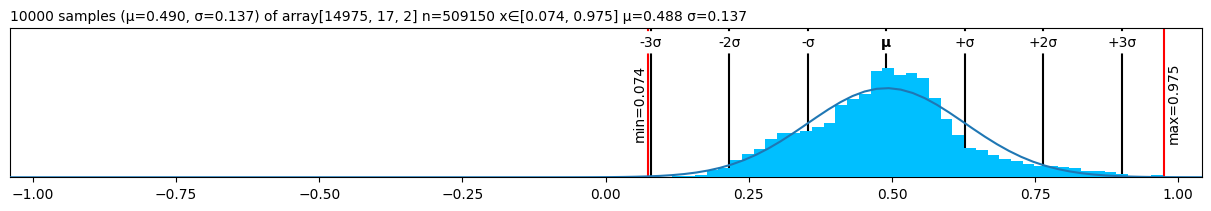

In [6]:
print(lo(X_normalized))
print(lo(y_normalized))
lo(X_normalized).plt

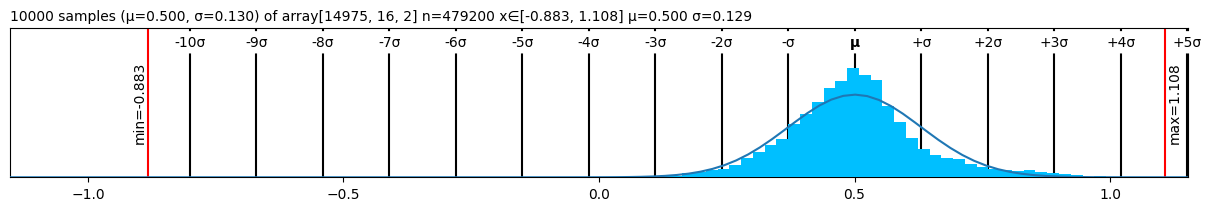

In [7]:
lo(y_normalized).plt


array[14975, 17, 2] n=509150 (3.9Mb) x∈[-0.139, 1.212] μ=0.483 σ=0.206


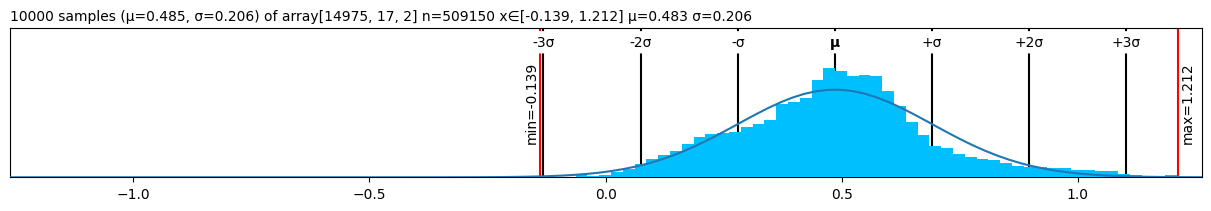

In [8]:
# box_scale = N x 1
# box_center = N x 2
# N x 16 x 2
def normalize1(data):
  # first width & height, but they are the same
  data = copy.deepcopy(data)
  # bbleft point N x 2
  scale_px = 200
  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]

  bbox_width = bbox_right - bbox_left
  data -= bbox_left[:, np.newaxis, :] 
  data /= bbox_width[:, np.newaxis, :]
  return data
  # bbright point
  # return data
X_normalized1 = normalize1(X)
print(lo(X_normalized1))
lo(X_normalized1).plt

array[14975, 16, 2] n=479200 (3.7Mb) x∈[-1.574, 1.412] μ=0.500 σ=0.194


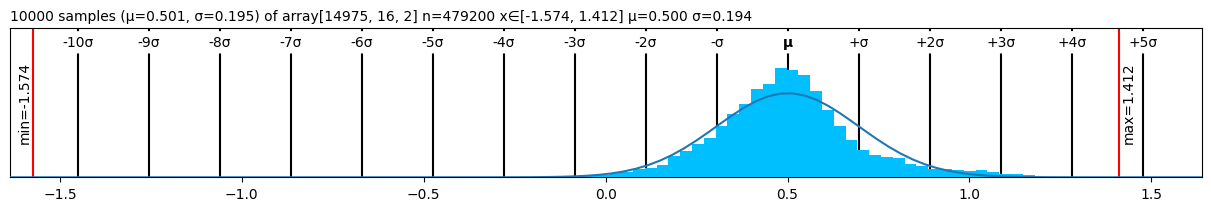

In [9]:
y_normalized1 = normalize1(y)
print(lo(y_normalized1))
lo(y_normalized1).plt

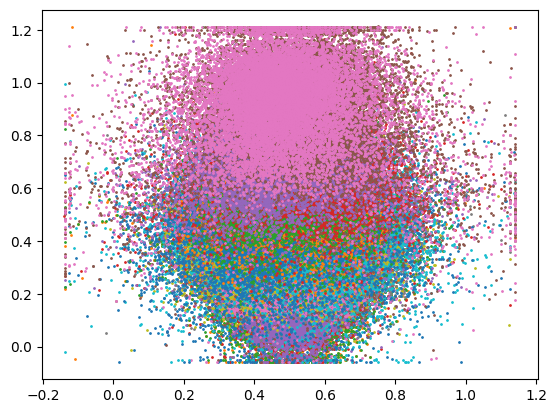

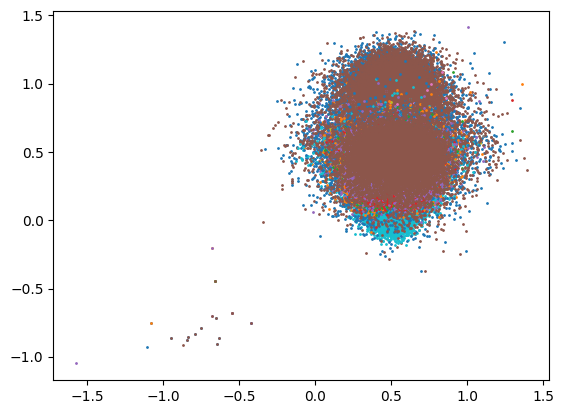

In [10]:
for i in range(17):
  plt.scatter(X_normalized1[:, i, 0],X_normalized1[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized1[:, i, 0],y_normalized1[:, i, 1], s=1)
plt.show()

## Figure out bounding box

In [11]:
import cv2
from IPython.display import Image, display
from info import MPII_INFO
dataset_info = MPII_INFO()

1905 057177235.jpg
[964.0, 303.0]
1.91113
[[1023.0, 638.0], [1004.0, 548.0], [973.0, 398.0], [934.0, 396.0], [909.0, 513.0], [885.0, 621.0], [954.0, 397.0], [953.0, 239.0], [953.0, 233.0], [953.0, 169.0], [1006.0, 96.0], [1007.0, 167.0], [996.0, 251.0], [909.0, 227.0], [916.0, 168.0], [916.0, 103.0]]
bbleft: (772, 111)
bbright: (1155, 494)


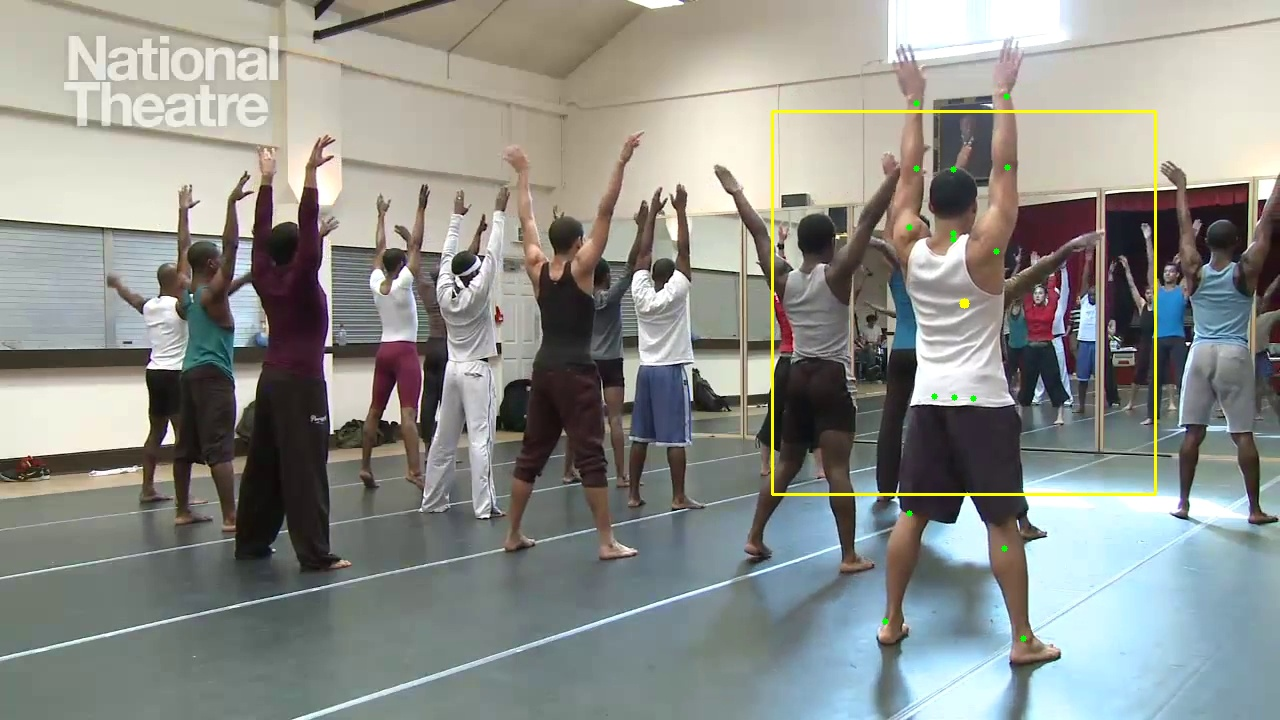

5885 094762366.jpg
[484.0, 355.0]
1.218576
[[479.0, 509.0], [490.0, 435.0], [496.0, 360.0], [453.0, 357.0], [464.0, 435.0], [479.0, 506.0], [475.0, 359.0], [461.0, 275.0], [456.4875, 257.1877], [446.5125, 217.8123], [484.0, 304.0], [507.0, 307.0], [491.0, 266.0], [430.0, 283.0], [436.0, 328.0], [455.0, 312.0]]
bbleft: (362, 233)
bbright: (605, 476)


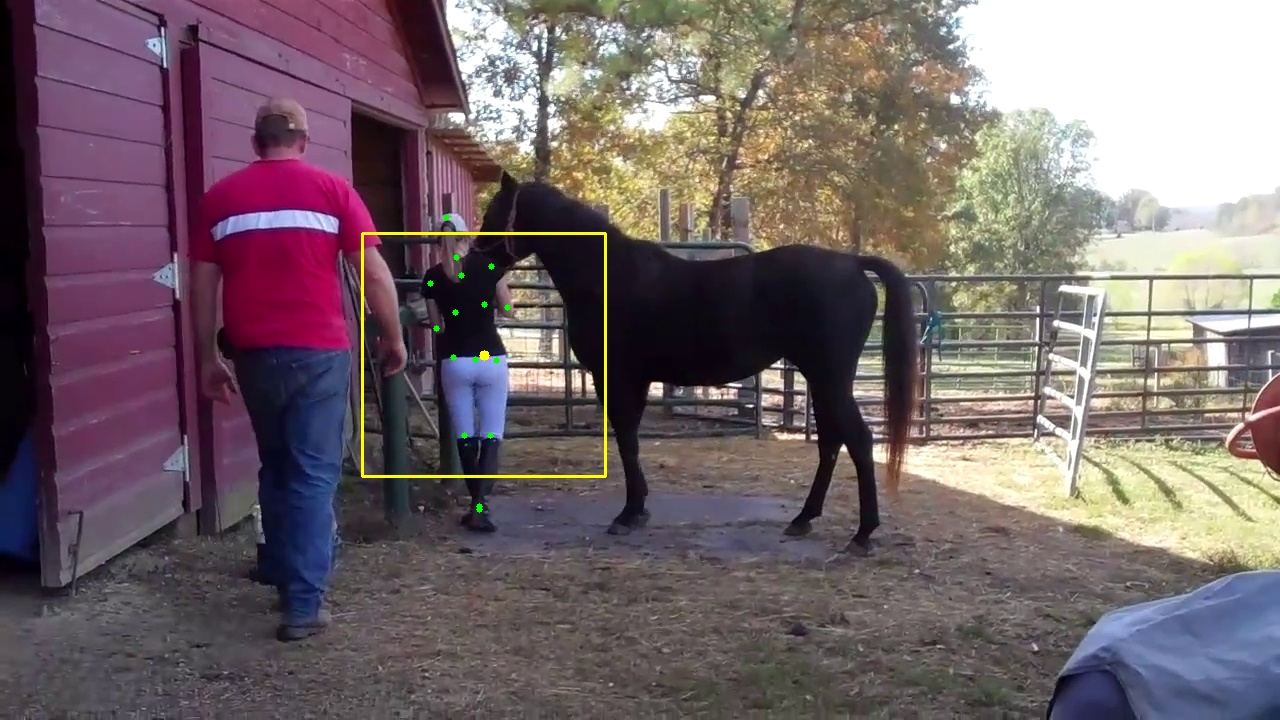

In [12]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_train.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)


NUM_IMAGES = 2

# choose image from ground truth
def choose_n_images(gt_json, num_images=10):
  random_numbers = np.random.randint(0, len(gt_json), size=num_images)
  images = list()
  for nums in random_numbers:
     images.append((nums,gt_json[nums]['image']))
  return images

for index, im_path in choose_n_images(annot_truth, NUM_IMAGES):
  print(index, im_path)
  # Load the image
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im_path)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[index]['joints']
  # pred
  print(annot_truth[index]['center'])
  print(annot_truth[index]['scale'])
  center = annot_truth[index]['center']
  scale = annot_truth[index]['scale']
  print(keypoints1)

  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  x_bounding_center, y_bounding_center = int(annot_truth[index]['center'][0]), int(annot_truth[index]['center'][1])
  cv2.circle(image, (x_bounding_center, y_bounding_center), 5, (0, 255, 255), -2 )

  scale_px = 200
  bbox_left = (int(center[0] - (scale_px * scale) / 2), int(center[1] - (scale_px * scale) / 2))
  bbox_right = (int(center[0] + (scale_px * scale) / 2), int(center[1] + (scale_px * scale) / 2))
  print("bbleft:", bbox_left)
  print("bbright:", bbox_right)
  cv2.rectangle(image, bbox_left, bbox_right, (0,255,255), 2)
  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results1/image{index}.jpg', image)

  display(Image(filename=f'tm_results1/image{index}.jpg'))


In [28]:
import scipy.io
dic = {}
mat = scipy.io.loadmat('/datagrid/personal/baljibil/data/MPII_COCO/annotations/official/mpii_human_pose_v1_u12_1.mat', dic)
# headboxes = np.array(mat['headboxes_src'])
# lo(headboxes)

In [27]:
dic

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Sep 23 22:09:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'RELEASE': array([[(array([[(array([[(array(['037454012.jpg'], dtype='<U13'),)]], dtype=[('name', 'O')]), array([[(array([[3.88073395]]), array([[(array([[601]], dtype=uint16), array([[380]], dtype=uint16))]],
                               dtype=[('x', 'O'), ('y', 'O')]))                                                         ]],
                       dtype=[('scale', 'O'), ('objpos', 'O')]), array([], shape=(1, 0), dtype=float64), array([], shape=(1, 0), dtype=float64))                                                      ,
                 (array([[(array(['095071431.jpg'], dtype='<U13'),)]], dtype=[('name', 'O')]), array([[(array([[8.07816613]]), array([[(array([[881]], dtype=uint16), array([[394]], dtype=uint16))]],
                               dtype=[('x', 'O'), ('y', 'O')]))                                                         ,
     

In [35]:
ann_list = []
img_list = []

head_rect_list = []
for _, (anno, train_flag) in enumerate(  # all images
  zip(mat['RELEASE']['annolist'][0, 0][0], mat['RELEASE']['img_train'][0, 0][0])):

  img_fn = anno['image']['name'][0, 0][0]
  img_list.append(img_fn)

  head_rect = []
  if 'x1' in str(anno['annorect'].dtype):
      head_rect = [
          [x1[0, 0] for x1 in anno['annorect']['x1'][0]], [y1[0, 0] for y1 in anno['annorect']['y1'][0]],
          [x2[0, 0] for x2 in anno['annorect']['x2'][0]], [y2[0, 0] for y2 in anno['annorect']['y2'][0]]
      ]
  else:
      head_rect = []  # TODO
  head_rect_list.append(head_rect)
print(img_list[:10])
print(head_rect_list[:10])

mat['RELEASE']['annolist'][0, 0][0]['annorect']



['037454012.jpg', '095071431.jpg', '073199394.jpg', '059865848.jpg', '015601864.jpg', '015599452.jpg', '005808361.jpg', '086617615.jpg', '060111501.jpg', '070807258.jpg']
[[], [], [], [], [[627, 841], [100, 145], [706, 902], [198, 228]], [[607, 903, 27], [70, 73, 36], [752, 1070, 186], [255, 263, 214]], [[914, 427], [79, 66], [1031, 549], [237, 221]], [[252, 510], [187, 265], [331, 580], [266, 343]], [[806], [56], [901], [183]], [[609, 652], [259, 301], [674, 716], [335, 364]]]


array([array([[(array([[3.88073395]]), array([[(array([[601]], dtype=uint16), array([[380]], dtype=uint16))]],
                     dtype=[('x', 'O'), ('y', 'O')]))                                                         ]],
             dtype=[('scale', 'O'), ('objpos', 'O')])                                                            ,
       array([[(array([[8.07816613]]), array([[(array([[881]], dtype=uint16), array([[394]], dtype=uint16))]],
                     dtype=[('x', 'O'), ('y', 'O')]))                                                         ,
               (array([[8.90412938]]), array([[(array([[338]], dtype=uint16), array([[210]], dtype=uint8))]],
                     dtype=[('x', 'O'), ('y', 'O')]))                                                        ]],
             dtype=[('scale', 'O'), ('objpos', 'O')])                                                           ,
       array([[(array([[4.32666153]]), array([[(array([[619]], dtype=uint16), array([[350]], dtype=u